In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [62]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [64]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [66]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [67]:
data_comb = pd.concat([train, test], sort=False)

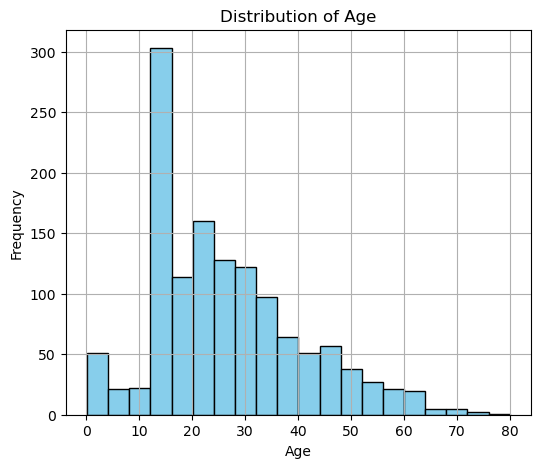

In [63]:
plt.figure(figsize=(6, 5))
plt.hist(data_comb['Age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.grid(True)
plt.show()


### We will fix the missing values from the column

In [68]:
data_comb.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [69]:
data_comb['Fare'].fillna(np.mean(data_comb['Fare']), inplace=True)

In [70]:
data_comb['Cabin'].isna().sum()

1014

### Since majority of values are null, we will not perform any operation on Cabin column

In [71]:
age_avg = data_comb['Age'].mean()
age_std = data_comb['Age'].std()

data_comb['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)

### Now we will encode the columns and convert them

In [72]:
label_enc = LabelEncoder()
data_comb['Sex'] = label_enc.fit_transform(data_comb['Sex'])
data_comb['Embarked'] = label_enc.fit_transform(data_comb['Embarked'])

In [73]:
data_comb['Age_class'] = ''
data_comb.loc[data_comb['Age'] < 18, 'Age_class'] = 'young'
data_comb.loc[(data_comb['Age'] >= 18) & (data_comb['Age'] <= 55), 'Age_class'] = 'middle'
data_comb.loc[data_comb['Age'] > 55, 'Age_class'] = 'old'

In [74]:
data_comb['trav_single'] = ''
data_comb['trav_single'].loc[((data_comb['SibSp'] + data_comb['Parch']) > 0)] = "no"
data_comb['trav_single'].loc[((data_comb['SibSp'] + data_comb['Parch']) == 0)] = "yes"

In [75]:
data_comb['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

In [76]:
data_comb['Initials'] = data_comb['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0]
data_comb['Initials'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

In [77]:
data_comb['Initials'] = data_comb['Initials'].apply(lambda x: 'Ladies' if any(char in x for char in [
    'Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona']) else x)

data_comb['Initials'] = data_comb['Initials'].apply(lambda x: 'Others' if any(char in x for char in [
    'Mr', 'Master', 'Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev']) else x)

In [78]:
data_comb['Initials'].unique()

array(['Others', 'Ladies'], dtype=object)

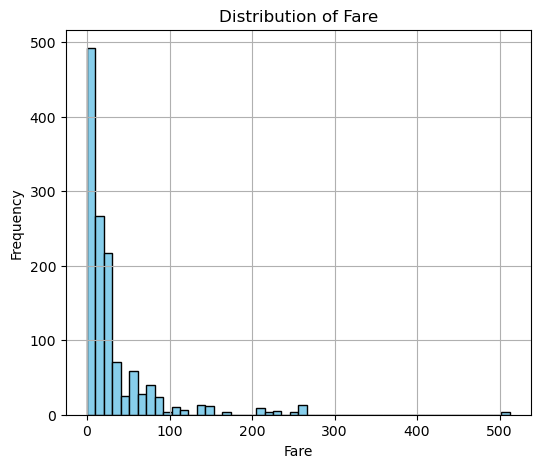

In [79]:
plt.figure(figsize=(6, 5))
plt.hist(data_comb['Fare'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Distribution of Fare')
plt.grid(True)
plt.show()


### based on the distribution we will take range till 300

In [80]:
data_comb['Fare_class'] = ''
data_comb.loc[(data_comb['Fare'] > 0) & (data_comb['Fare'] < 100), 'Fare_class'] = 'economy'
data_comb.loc[(data_comb['Fare'] >= 100) & (data_comb['Fare'] < 300), 'Fare_class'] = 'premium'
data_comb.loc[(data_comb['Fare'] >= 300), 'Fare_class'] = 'deluxe'

In [81]:
data_comb['Ticket_sum'] = data_comb.groupby('Ticket')['Ticket'].transform('count')

In [82]:
data_comb['Age_class'] = label_enc.fit_transform(data_comb['Age_class'])
data_comb['trav_single'] = label_enc.fit_transform(data_comb['trav_single'])
data_comb['Initials'] = label_enc.fit_transform(data_comb['Initials'])
data_comb['Fare_class'] = label_enc.fit_transform(data_comb['Fare_class'])

In [83]:
data_comb.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_class,trav_single,Initials,Fare_class,Ticket_sum
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,0,0,1,2,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,2,2
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,0,1,0,2,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,0,0,0,2,2
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,0,1,1,2,1


### now our data is ready !!!

In [84]:
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
data_comb = data_comb.drop(drop_cols, axis = 1)

In [85]:
train = data_comb[:len(train)]
test = data_comb[len(train):]

In [86]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_class,trav_single,Initials,Fare_class,Ticket_sum
0,0.0,3,1,22.0,1,0,7.2500,2,0,0,1,2,1
1,1.0,1,0,38.0,1,0,71.2833,0,0,0,0,2,2
2,1.0,3,0,26.0,0,0,7.9250,2,0,1,0,2,1
3,1.0,1,0,35.0,1,0,53.1000,2,0,0,0,2,2
4,0.0,3,1,35.0,0,0,8.0500,2,0,1,1,2,1


In [87]:
test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_class,trav_single,Initials,Fare_class,Ticket_sum
0,NaN,3,1,34.5,0,0,7.8292,1,0,1,1,2,1
1,NaN,3,0,47.0,1,0,7.0000,2,0,0,0,2,1
2,NaN,2,1,62.0,0,0,9.6875,1,1,1,1,2,1
3,NaN,3,1,27.0,0,0,8.6625,2,0,1,1,2,1
4,NaN,3,0,22.0,1,1,12.2875,2,0,0,0,2,2


In [89]:
classifiers = [
    KNeighborsClassifier(10),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression()]


X = train.drop(columns=['Survived'])
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Clf {} acc {}".format(clf, acc))

Clf KNeighborsClassifier(n_neighbors=10) acc 0.7262569832402235
Clf SVC(probability=True) acc 0.659217877094972
Clf DecisionTreeClassifier() acc 0.770949720670391
Clf RandomForestClassifier() acc 0.8324022346368715
Clf AdaBoostClassifier() acc 0.7988826815642458
Clf GradientBoostingClassifier() acc 0.8100558659217877
Clf GaussianNB() acc 0.770949720670391
Clf LogisticRegression() acc 0.7932960893854749


### based on above analysis, we can pic RandomForestClassifier

In [95]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
X_test = test.drop('Survived', axis = 1)
train_predictions = clf.predict(X_test)

In [96]:
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")
sub = gender_submission
sub['Survived'] = list(map(int, train_predictions))
sub.to_csv("submission.csv", index=False)